In [1]:
#Import libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [2]:
#load in our dataset
df = pd.read_csv("Resources/mountain_pastured_cows.csv")
display(df.head())

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


### Data Exploration

In [3]:
#check dtypes
df.dtypes

newid               int64
lact_num            int64
calv_date          object
alp_date           object
avg_milk          float64
avg_thi3          float64
avg_csi3          float64
avg_thi30         float64
avg_csi30         float64
avg_precspring    float64
dtype: object

In [4]:
#check for nulls, negligible amount, should be clear to dropna
print(df.isna().sum()/len(df))
print(df.shape)

newid             0.00000
lact_num          0.00000
calv_date         0.00000
alp_date          0.00000
avg_milk          0.00000
avg_thi3          0.00205
avg_csi3          0.00205
avg_thi30         0.00205
avg_csi30         0.00205
avg_precspring    0.00000
dtype: float64
(20000, 10)


In [5]:
df = df.dropna()
print(df.shape)

(19959, 10)


In [6]:
df["avg_milk"].describe()

count    19959.000000
mean        15.921083
std          4.078102
min          3.500000
25%         13.070000
50%         15.600000
75%         18.500000
max         40.370000
Name: avg_milk, dtype: float64

In [7]:
# The most frequently produced milk production value (mode)
mode_milk = stats.mode(df['avg_milk'])[0]  

# Print the mode
print(f"Mode of avg_milk: {mode_milk}") 

Mode of avg_milk: 14.6


In [8]:
# For the Target column ("Y"), avg_milk production, calculate the number of cows for the min and max, 
# and calculate the cumulative number of cows at quartiles 25%, 50% and 75% (moooooooooooooooo!!!!)
min_milk_count = (df['avg_milk'] == df['avg_milk'].min()).sum()
max_milk_count = (df['avg_milk'] == df['avg_milk'].max()).sum()
p25_count = (df['avg_milk'] < df['avg_milk'].quantile(0.25)).sum()
p50_count = (df['avg_milk'] < df['avg_milk'].quantile(0.50)).sum()
p75_count = (df['avg_milk'] < df['avg_milk'].quantile(0.75)).sum()

# print the cumlative number of cows below the certain thresholds)
print(f"Number of cows with minimum milk production (3.5 kg): {min_milk_count}")
print(f"Number of cows with maximum milk production (40.37 kg): {max_milk_count}")
print(f"Number of cows that produced less than the 25th percentile (13.07 kg): {p25_count}") 
print(f"Number of cows that produced less than the median (15.60 kg): {p50_count}")
print(f"Number of cows that produced less than the 75th percentile (18.50 kg): {p75_count}")


Number of cows with minimum milk production (3.5 kg): 1
Number of cows with maximum milk production (40.37 kg): 2
Number of cows that produced less than the 25th percentile (13.07 kg): 4979
Number of cows that produced less than the median (15.60 kg): 9911
Number of cows that produced less than the 75th percentile (18.50 kg): 14965


In [9]:
# Extact from the dataset and examine the data of the cow with exceptionally low milk yield to gather some insight behind these values.

# Find the cow(s) that produced 3.5 kg of milk
cows_with_min_milk = df[df['avg_milk'] == 3.5] 
cows_with_min_milk


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
3844,37340,2,2001-09-29,2002-07-03,3.5,59.18,1091.85,60.98,1040.56,186.71


In [10]:
# Extact from the dataset and examine the data of the cow with exceptionally high milk yield to gather some insight behind these values.

# Find the cow(s) that produced 40.37 kg of milk:
cows_with_max_milk = df[df['avg_milk'] == 40.37] 
cows_with_max_milk

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
3923,176146,8,2013-09-28,2013-10-09,40.37,44.27,1088.68,46.34,1140.58,182.28
6922,376495,8,2013-09-28,2013-10-09,40.37,44.27,1088.68,46.34,1140.58,182.28


Number of cows within 1 standard deviation: 13753
Number of cows within 2 standard deviations: 19067
Number of cows within 3 standard deviations: 19865


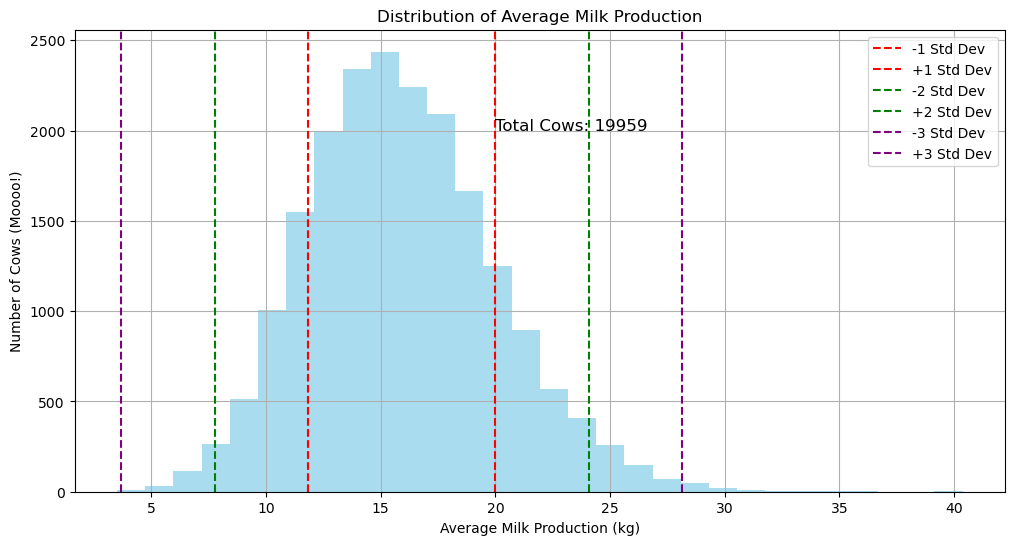

In [11]:
# For the defined target Column ("Y"), avg_milk production, 
# calculate and observe the number of cows within 1 standard deviation, 2 and 3 standard deviations and graph the results 

# Extract relevant statistics
mean = 15.921083
std_dev = 4.078102
total_cows = 19959

# Calculate standard deviation boundaries
lower_bound_1std = mean - std_dev
upper_bound_1std = mean + std_dev
lower_bound_2std = mean - 2 * std_dev
upper_bound_2std = mean + 2 * std_dev
lower_bound_3std = mean - 3 * std_dev
upper_bound_3std = mean + 3 * std_dev

# Count cows within standard deviation ranges 
num_cows_within_1std = ((df['avg_milk'] >= lower_bound_1std) & (df['avg_milk'] <= upper_bound_1std)).sum()
num_cows_within_2std = ((df['avg_milk'] >= lower_bound_2std) & (df['avg_milk'] <= upper_bound_2std)).sum()
num_cows_within_3std = ((df['avg_milk'] >= lower_bound_3std) & (df['avg_milk'] <= upper_bound_3std)).sum()

# Print the number of cows within each standard deviation range
print(f"Number of cows within 1 standard deviation: {num_cows_within_1std}")
print(f"Number of cows within 2 standard deviations: {num_cows_within_2std}")
print(f"Number of cows within 3 standard deviations: {num_cows_within_3std}")

# Create the histogram
plt.figure(figsize=(12, 6))

plt.hist(df['avg_milk'], bins=30, color='skyblue', alpha=0.7)

# Plot vertical lines for standard deviations
plt.axvline(lower_bound_1std, color='red', linestyle='--', label='-1 Std Dev')
plt.axvline(upper_bound_1std, color='red', linestyle='--', label='+1 Std Dev')
plt.axvline(lower_bound_2std, color='green', linestyle='--', label='-2 Std Dev')
plt.axvline(upper_bound_2std, color='green', linestyle='--', label='+2 Std Dev')
plt.axvline(lower_bound_3std, color='purple', linestyle='--', label='-3 Std Dev')
plt.axvline(upper_bound_3std, color='purple', linestyle='--', label='+3 Std Dev')

# Add labels and title
plt.xlabel('Average Milk Production (kg)')
plt.ylabel('Number of Cows (Moooo!)')
plt.title('Distribution of Average Milk Production')
plt.legend()

# Add gridlines
plt.grid(True)

# Add total number of cows as text
plt.text(20, 2000, f"Total Cows: {total_cows}", fontsize=12)

plt.show()

### Feature Engineering

In [12]:
# Example: converting 'calv_date' and 'alp_date' columns to datetime
df['calv_date'] = pd.to_datetime(df['calv_date'])
df['alp_date'] = pd.to_datetime(df['alp_date'])

display(df.head())
print(df.dtypes)


,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


newid                      int64
lact_num                   int64
calv_date         datetime64[ns]
alp_date          datetime64[ns]
avg_milk                 float64
avg_thi3                 float64
avg_csi3                 float64
avg_thi30                float64
avg_csi30                float64
avg_precspring           float64
dtype: object


In [13]:
# Calculate the difference
df['date_diff'] = (df['alp_date'] - df['calv_date']).dt.days

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262


In [14]:
#Replace datetime columns with numerical

# df['calv_year'] = df['calv_date'].dt.year | causes multicollinearity issues
df['calv_month'] = df['calv_date'].dt.month
df['calv_day_of_month'] = df['calv_date'].dt.day

# df['alp_year'] = df['alp_date'].dt.year | causes multicollinearity issues
df['alp_month'] = df['alp_date'].dt.month
df['alp_day_of_month'] = df['alp_date'].dt.day

df.head()

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61,106,2,19,6,5
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40,218,11,9,6,15
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08,281,9,16,6,24
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96,254,10,18,6,29
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72,262,9,14,6,2


In [15]:
df.dtypes

newid                         int64
lact_num                      int64
calv_date            datetime64[ns]
alp_date             datetime64[ns]
avg_milk                    float64
avg_thi3                    float64
avg_csi3                    float64
avg_thi30                   float64
avg_csi30                   float64
avg_precspring              float64
date_diff                     int64
calv_month                    int32
calv_day_of_month             int32
alp_month                     int32
alp_day_of_month              int32
dtype: object

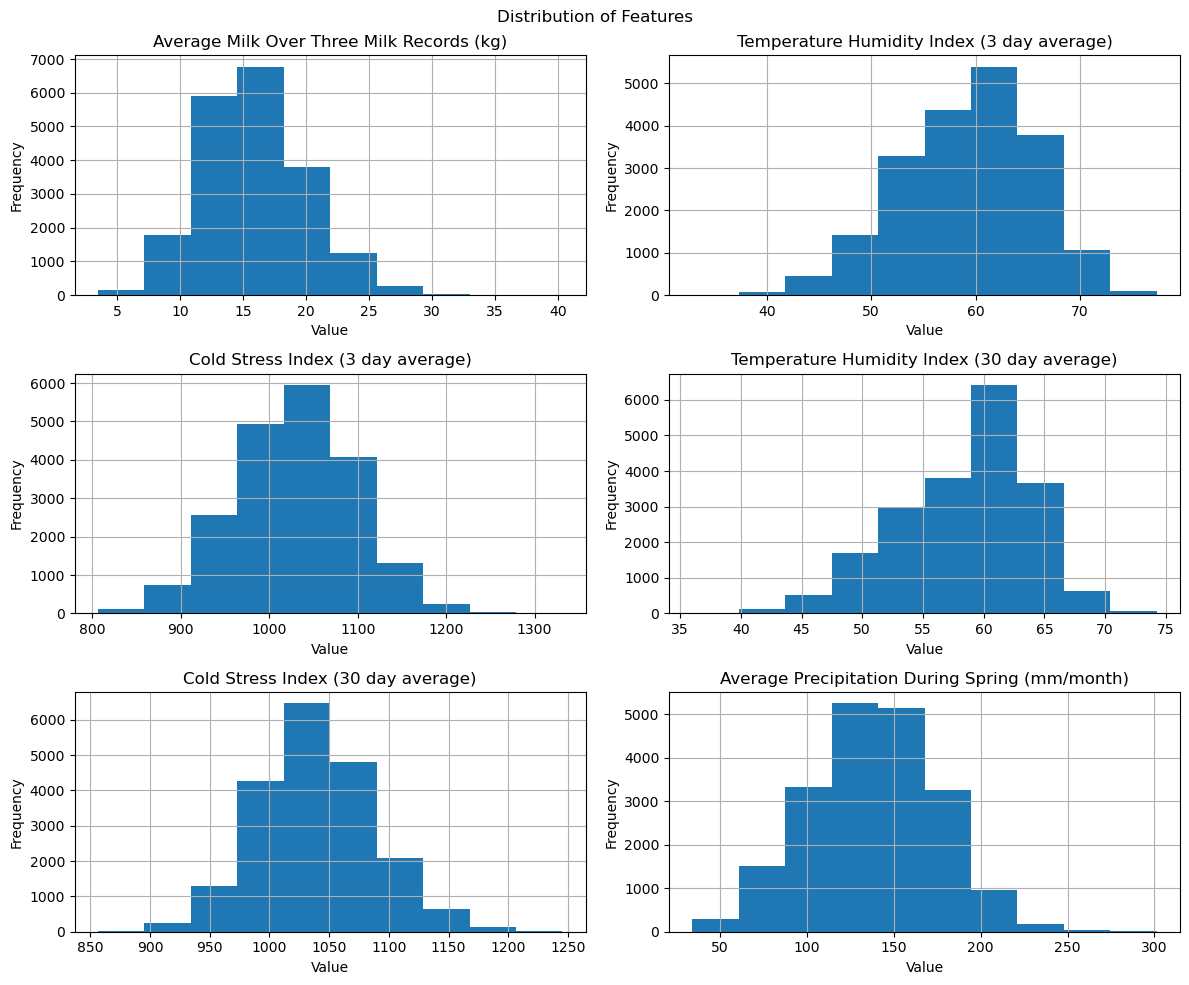

<Figure size 640x480 with 0 Axes>

In [16]:
# Visualize distributions of numeric columns
numeric_columns = ['avg_milk', 'avg_thi3', 'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring']
axes = df[numeric_columns].hist(figsize=(12, 10))
plt.suptitle("Distribution of Features")
# Add Labels for each fig
titles = ['Average Milk Over Three Milk Records (kg)', 'Temperature Humidity Index (3 day average)', 'Cold Stress Index (3 day average)',
          'Temperature Humidity Index (30 day average)','Cold Stress Index (30 day average)', 'Average Precipitation During Spring (mm/month)']
xlabel = "Value"
ylabel = "Frequency"
for fig, title in zip(axes.flatten(), titles):
    fig.set_title(title)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
# show charts
plt.tight_layout()
plt.show()
plt.savefig('Resources/milk_histogram.svg')

## Preporccessing Data

### Data Leakage 

In [17]:
df.columns

Index(['newid', 'lact_num', 'calv_date', 'alp_date', 'avg_milk', 'avg_thi3',
       'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring', 'date_diff',
       'calv_month', 'calv_day_of_month', 'alp_month', 'alp_day_of_month'],
      dtype='object')

In [18]:
features = ['lact_num', 'avg_milk', 'avg_thi3', 'avg_csi3', 'avg_csi30',
       'avg_precspring', 'date_diff', 'calv_month',
       'calv_day_of_month', 'alp_month', 'alp_day_of_month']

# Calculate VIF
X = df[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature          VIF
0               const  4350.541432
1            lact_num     1.093165
2            avg_milk     1.583383
3            avg_thi3     6.963646
4            avg_csi3     3.926807
5           avg_csi30     2.587901
6      avg_precspring     1.268668
7           date_diff     2.117705
8          calv_month     2.834302
9   calv_day_of_month     1.015470
10          alp_month     1.502374
11   alp_day_of_month     1.388929


In [19]:
# remove problematic or no longer needed columns
df = df.drop(["newid",'avg_thi30', 'calv_date', 'alp_date'], axis = 1)
df.head()

,lact_num,avg_milk,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,26.20,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,12.20,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,14.60,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,15.17,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,12.03,65.96,969.90,998.60,154.72,262,9,14,6,2


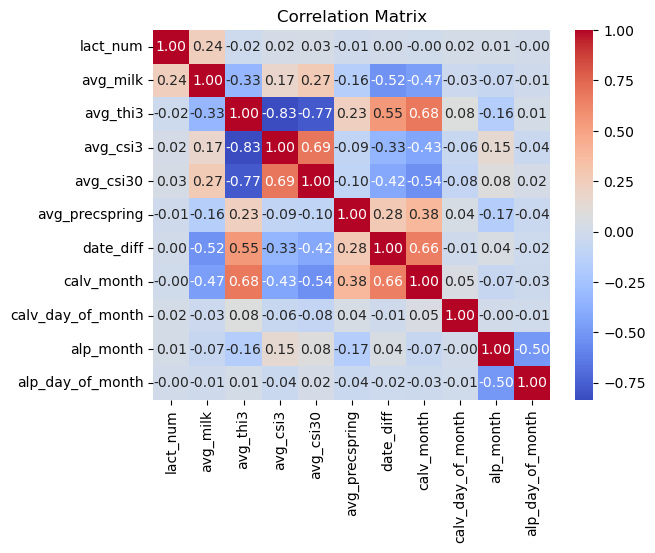

In [20]:
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Model Training 

In [21]:
# Split the features and target data
y = df['avg_milk']
X = df.drop('avg_milk', axis = 1)


In [22]:
# Review the features Dataframe 
display(X.head())
display(y)

,lact_num,avg_thi3,avg_csi3,avg_csi30,avg_precspring,date_diff,calv_month,calv_day_of_month,alp_month,alp_day_of_month
0,5,60.17,966.13,1038.28,134.61,106,2,19,6,5
1,5,66.08,917.76,1111.54,184.40,218,11,9,6,15
2,3,66.78,899.06,1000.32,184.08,281,9,16,6,24
3,5,63.49,1053.80,1037.26,116.96,254,10,18,6,29
4,1,65.96,969.90,998.60,154.72,262,9,14,6,2


0        26.20
1        12.20
2        14.60
3        15.17
4        12.03
         ...  
19995    19.38
19996    23.57
19997    21.23
19998    11.63
19999    10.47
Name: avg_milk, Length: 19959, dtype: float64

In [23]:
# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [24]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

display(X_train_scaled)
display(X_test_scaled)

array([[-0.30741166, -0.21155819,  0.13192995, ...,  0.72095697,
        -1.96420227,  1.46995656],
       [ 0.77316723, -0.92933445,  1.23760228, ...,  1.29769942,
        -0.0429958 , -0.49693931],
       [ 0.77316723,  0.20266511, -0.55633228, ...,  1.5283964 ,
        -0.0429958 ,  1.00715753],
       ...,
       [-0.84770111, -2.32219983,  1.51317257, ..., -0.54787644,
        -0.0429958 ,  0.66005826],
       [-0.30741166, -1.31193765,  1.0039057 , ...,  0.72095697,
        -0.0429958 ,  0.19725924],
       [-0.84770111,  0.52835213, -0.04441145, ...,  0.60560848,
        -0.0429958 , -1.65393688]])

array([[-0.30741166,  0.43665384, -0.35566286, ..., -0.31717945,
        -0.0429958 ,  1.46995656],
       [ 0.77316723, -1.02419475,  0.92340202, ...,  1.75909339,
        -0.0429958 , -0.95973833],
       [-0.84770111, -0.20365317, -0.2365292 , ..., -0.54787644,
        -1.96420227,  0.77575802],
       ...,
       [ 0.77316723,  1.69197179, -1.64165754, ...,  0.259563  ,
        -1.96420227,  1.3542568 ],
       [ 0.23287778, -1.17280921,  0.7967488 , ..., -1.47066437,
        -0.0429958 , -0.95973833],
       [-0.84770111,  1.08960889, -1.31315534, ...,  0.02886602,
        -0.0429958 , -0.38123955]])

## Define the ANN Model

### Create and fit feedforward ANN Model 

In [25]:
# Define the ANN Model
model = Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer 1
    layers.Dense(32, activation='relu'),  # Hidden layer 2
    layers.Dense(1)  # Output layer
])

In [26]:
# Compile the ANN ›model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [27]:
# Fit the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.2)

Epoch 1/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 68.2872 - mae: 6.1649 - val_loss: 12.2157 - val_mae: 2.7145
Epoch 2/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.8475 - mae: 2.6984 - val_loss: 10.8579 - val_mae: 2.5471
Epoch 3/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.6686 - mae: 2.5197 - val_loss: 10.0807 - val_mae: 2.4718
Epoch 4/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.9976 - mae: 2.4610 - val_loss: 10.0262 - val_mae: 2.4421
Epoch 5/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.9019 - mae: 2.4484 - val_loss: 9.7106 - val_mae: 2.4388
Epoch 6/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8086 - mae: 2.4335 - val_loss: 9.9160 - val_mae: 2.4845
Epoch 7/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.6883 - mae: 2.4188 - val_loss: 9.6972 - val_mae: 2.4373
Epoch 8/100
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8799 - mae: 2.4322 - val_loss: 9.5730 - val_mae: 2.3991
Epoch 9/100
1198/1198 ━━━

In [28]:
# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Mean Absolute Error: {mae}')

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3732 - mae: 2.4136
Mean Absolute Error: 2.452927589416504


In [29]:
# Calculate MAE ********  (For readressing  / review)
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
# Calculate the mean of actual values
mean_actual = np.mean(y_test)
# Calculate the percentage MAE
percentage_mae = (mae / mean_actual) * 100
print(f"Percentage MAE: {percentage_mae:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
Percentage MAE: 15.34%


MAPE indicates that the model's predictions deviate from the true values by an average of 5.56%

In [30]:
from tensorflow.keras.optimizers import Adam
# Define a fine-tuned ANN Model
model_finetuned = Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer 1 (increased neurons)
    layers.Dense(64, activation='relu'),  # Hidden layer 2 (increased neurons)
    layers.Dense(1)  # Output layer
])

# Compile the model with a lower learning rate
model_finetuned.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Fit the model
model_finetuned.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2)

# Evaluate the fine-tuned model
loss, mae = model_finetuned.evaluate(X_test_scaled, y_test)
print(f"Fine-tuned Mean Absolute Error: {mae}")

Epoch 1/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 98.9655 - mae: 7.9095 - val_loss: 13.4279 - val_mae: 2.8563
Epoch 2/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.6087 - mae: 2.7788 - val_loss: 11.1400 - val_mae: 2.5860
Epoch 3/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.9446 - mae: 2.5688 - val_loss: 10.3914 - val_mae: 2.5355
Epoch 4/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.2735 - mae: 2.4756 - val_loss: 10.2612 - val_mae: 2.5223
Epoch 5/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8425 - mae: 2.4329 - val_loss: 9.9276 - val_mae: 2.4237
Epoch 6/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8827 - mae: 2.4317 - val_loss: 9.7127 - val_mae: 2.4239
Epoch 7/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7820 - mae: 2.4069 - val_loss: 9.8205 - val_mae: 2.4162
Epoch 8/200
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3689 - mae: 2.3912 - val_loss: 9.5555 - val_mae: 2.3884
Epoch 9/200
375/375 ━━━━━━━━━━━━━━━━━━━━

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


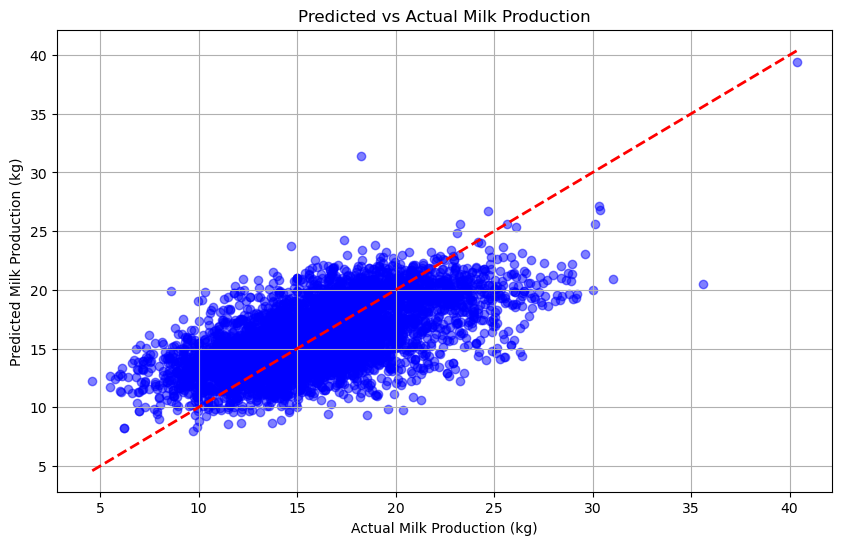

In [31]:
import matplotlib.pyplot as plt

# Make predictions using the fine-tuned model
y_pred_finetuned = model_finetuned.predict(X_test_scaled)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred_finetuned, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal line (y = x)

plt.title('Predicted vs Actual Milk Production')
plt.xlabel('Actual Milk Production (kg)')
plt.ylabel('Predicted Milk Production (kg)')
plt.grid(True)
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_finetuned)

# Display MAE
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.489235313671624


In [33]:
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Define the model with tuned hyperparameters
def build_model(hp):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))
    
    # Hyperparameter for number of hidden layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, default=2)
    
    # Add hidden layers based on num_layers
    for i in range(num_layers):
        model.add(layers.Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        ))
        
        # Optionally add dropout
        if hp.Boolean('dropout_' + str(i)):
            model.add(layers.Dropout(rate=hp.Float('dropout_rate_' + str(i), min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1))  # Since we're predicting a continuous variable
    
    # Hyperparameter for optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'), momentum=0.9)
    else:  # 'rmsprop'
        optimizer = RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

# Initialize Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  # Objective metric to minimize
    max_epochs=20,
    hyperband_iterations=2,
    directory='kt_dir',
    project_name='milk_prediction_tuning_extended'
)

# Display the search space
tuner.search_space_summary()

# prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter tuning
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters found
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# Evaluate the best model
loss, mae = best_model.evaluate(X_test_scaled, y_test)
print(f'Best model - Mean Absolute Error: {mae}')

Reloading Tuner from kt_dir\milk_prediction_tuning_extended\tuner0.json
Search space summary
Default search space size: 13
num_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_1 (Boolean)
{'default': False, 'conditions': []}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout_rate_0 (Float)
{'default': 0.1, 'conditions

C:\Users\Owner\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
{'num_layers': 2, 'units_0': 128, 'activation': 'relu', 'dropout_0': True, 'units_1': 96, 'dropout_1': True, 'optimizer': 'sgd', 'learning_rate': 0.0026086705570348132, 'dropout_rate_0': 0.1, 'units_2': 32, 'dropout_2': True, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.30000000000000004, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1413 - mae: 2.3639
Best model - Mean Absolute Error: 2.4120843410491943


Epoch 1/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 123.1556 - mae: 9.3990 - val_loss: 16.7450 - val_mae: 3.1162
Epoch 2/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37.2404 - mae: 4.8055 - val_loss: 13.9811 - val_mae: 2.8343
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 31.3425 - mae: 4.3628 - val_loss: 13.3798 - val_mae: 2.7677
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 28.7715 - mae: 4.2071 - val_loss: 12.4397 - val_mae: 2.6817
Epoch 5/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.8188 - mae: 4.0339 - val_loss: 11.9867 - val_mae: 2.6324
Epoch 6/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 25.0211 - mae: 3.9038 - val_loss: 11.8877 - val_mae: 2.6242
Epoch 7/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.7074 - mae: 3.7903 - val_loss: 12.6892 - val_mae: 2.7171
Epoch 8/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.3653 - mae: 3.7815 - val_loss: 11.0563 - val_mae: 2.5445
Epoch 9/100
468/468 ━━━━━━━━━━━

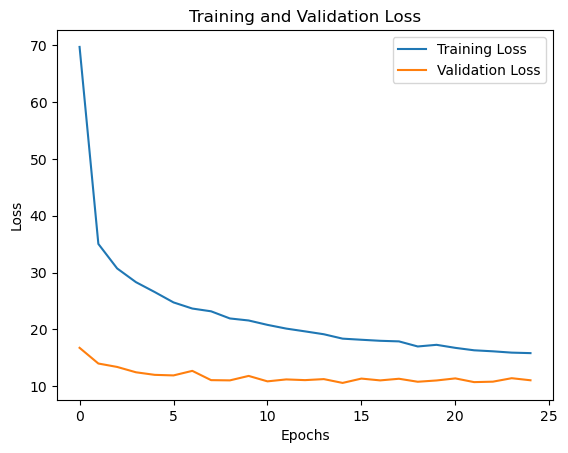

In [34]:


from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

# Load your dataset
# df = pd.read_csv("milk_data.csv")

# For demonstration purposes, we assume df is already loaded
# and preprocessed (similar to your previous steps)


# Define the ANN model with dropout and L2 regularization
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer 1 with L2 regularization
    layers.Dropout(0.5),  # Dropout layer
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer 2 with L2 regularization
    layers.Dropout(0.5),  # Dropout layer
    layers.Dense(1)  # Output layer (regression)
])

# Compile the model with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model to the training data
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Mean Absolute Error: {mae}')

# Calculate the predicted values
y_pred = model.predict(X_test_scaled)

# Calculate and print the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Plot training and validation loss to visualize overfitting prevention
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()